In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Pg 126

import pandas as pd

df = pd.read_csv('../data/bandwidth.csv')    # shape (10000, 1)

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


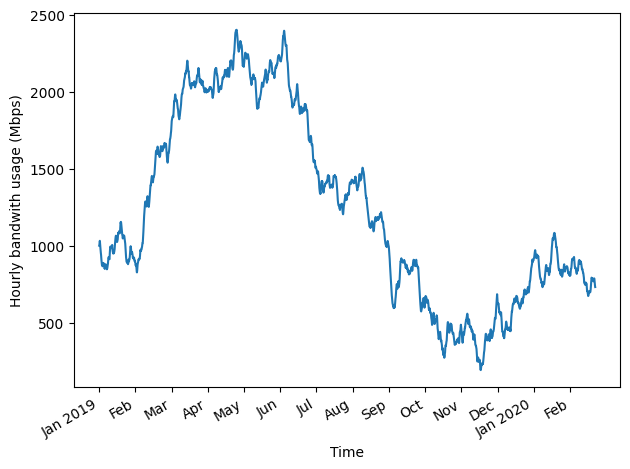

In [3]:
# Figure 6.15 in pg 126
# Figure 6.1 in pg 103

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (Mbps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

We are going to work with train portion of dataset only since the beginning. Later, we will forecast the test portion and measure the forecast error

In [4]:
train = df[:-168]
test = df[-168:]

print(len(train))
print(len(test))

9832
168


In [5]:
ADF_result = adfuller(train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -0.8222075294645101
p-value: 0.8125115848431818


In [6]:
hourly_bandwidth_diff_train = np.diff(train['hourly_bandwidth'], n=1)

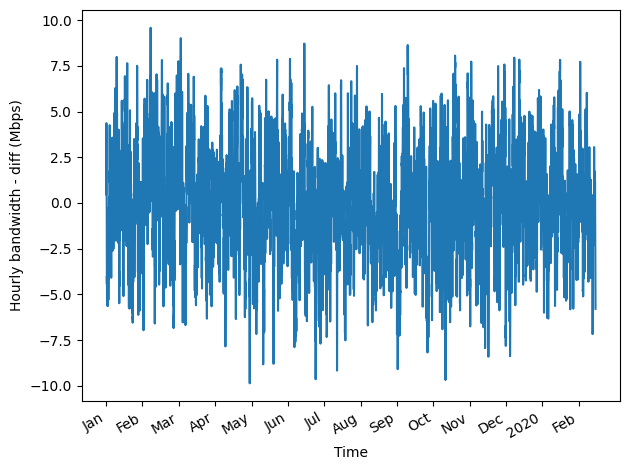

In [7]:
fig, ax = plt.subplots()

ax.plot(hourly_bandwidth_diff_train)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (Mbps)')

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [8]:
ADF_result = adfuller(hourly_bandwidth_diff_train)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.526228992356803
p-value: 0.0


First-order differencing makes it stationary. We could use ARIMA d=1

In [9]:
# ARIMA integrated coefficient
d = 1

In [10]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [12]:
result_df = optimize_ARIMA(train['hourly_bandwidth'], order_list, d) # we send the original series, not the differencing
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


Interesting, ARIMA(3,1,2) and ARIMA(2,1,3) would be the best model.   
ARIMA(2,1,2) is very close. Let's look at ACF and PACF

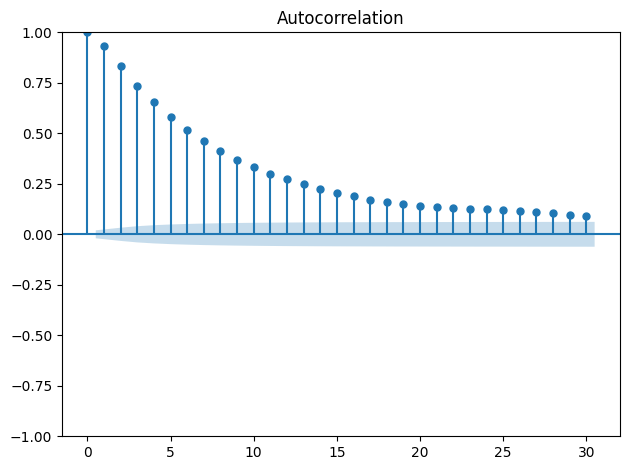

In [13]:
plot_acf(hourly_bandwidth_diff_train, lags=30)

plt.tight_layout()

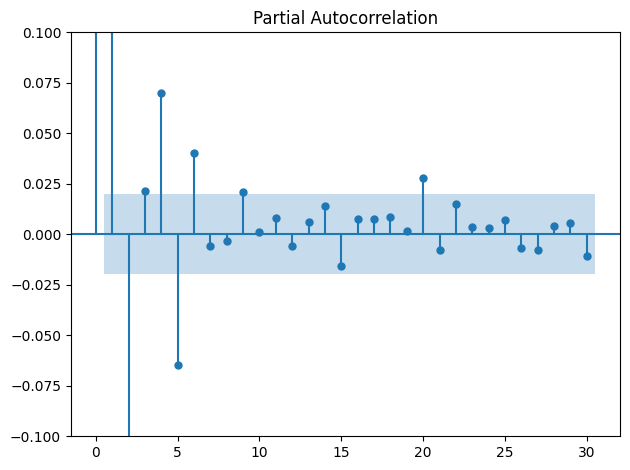

In [14]:
plot_pacf(hourly_bandwidth_diff_train, lags=30)
plt.ylim(-0.1,0.1)

plt.tight_layout()

Slow decay and sinusoidal. And it looks like we need both AR and MA. Not helpful to decide, the three(3) options contain both.  
Because almost same AIC, we will pick the one with the lesser amount of coefficients.  
Let's try ARIMA(2,1,2). Let's do residual analysis 

In [15]:
model = SARIMAX(train, order=(2,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Mon, 09 Feb 2026   AIC                          27991.603
Time:                        16:06:23   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

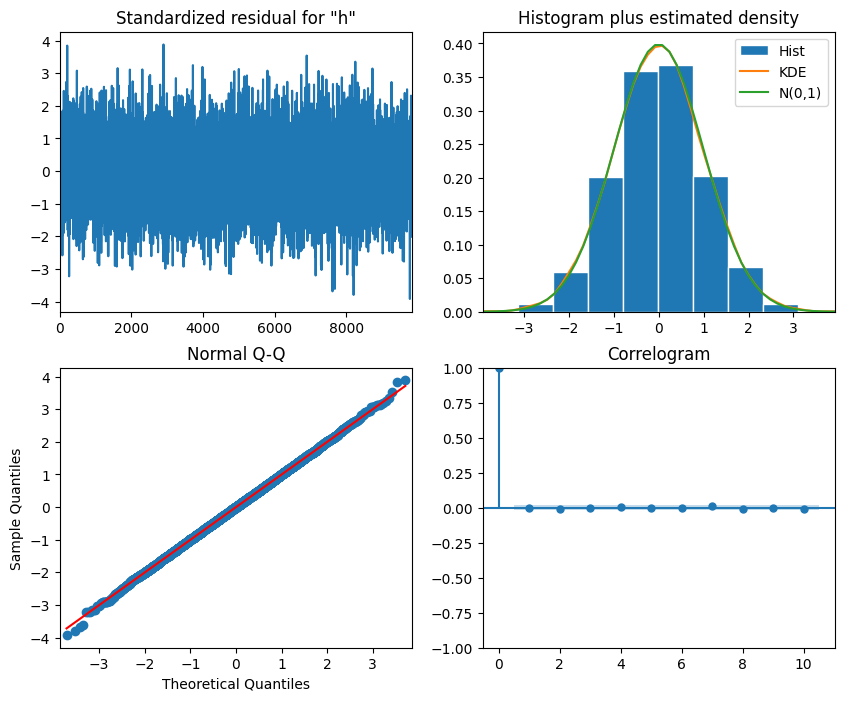

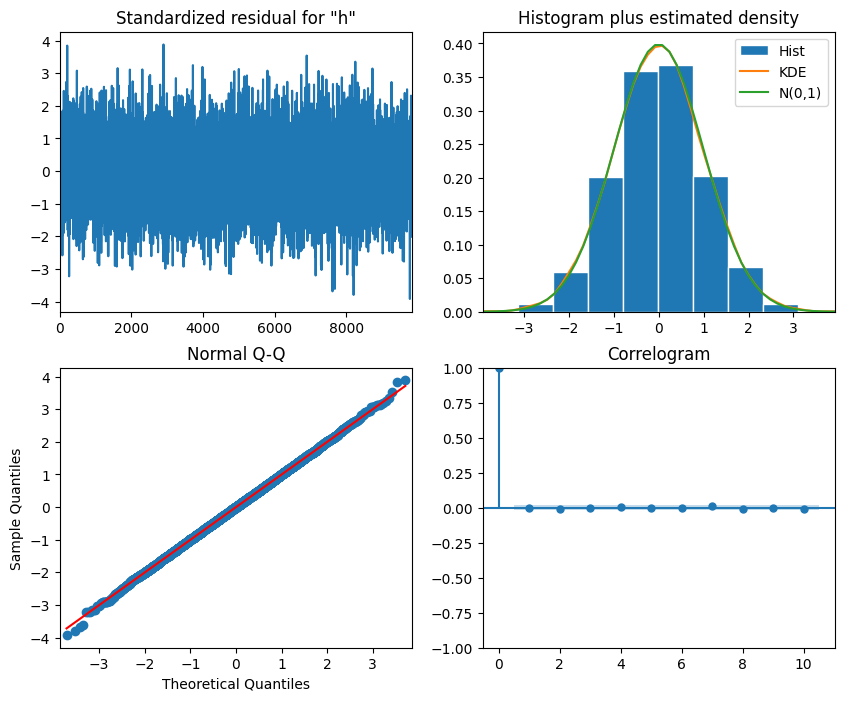

In [16]:
model_fit.plot_diagnostics(figsize=(10,8))

Residuals resemble white noise: normally distributed and uncorrelated

In [17]:
residuals = model_fit.resid

lb_dataframe = acorr_ljungbox(residuals, np.arange(1, 21, 1))

lb_dataframe

,lb_stat,lb_pvalue
1,0.001923,0.965020
2,0.005134,0.997436
3,0.025881,0.998901
4,0.025943,0.999917
5,0.026603,0.999994
6,0.049674,0.999997
7,0.057616,1.000000
8,0.060490,1.000000
9,0.063568,1.000000
10,0.065937,1.000000


Residuals are uncorrelated

### Model ready for forecast

In [18]:
hourly_bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)
df_diff = pd.DataFrame({'hourly_bandwidth_diff': hourly_bandwidth_diff})

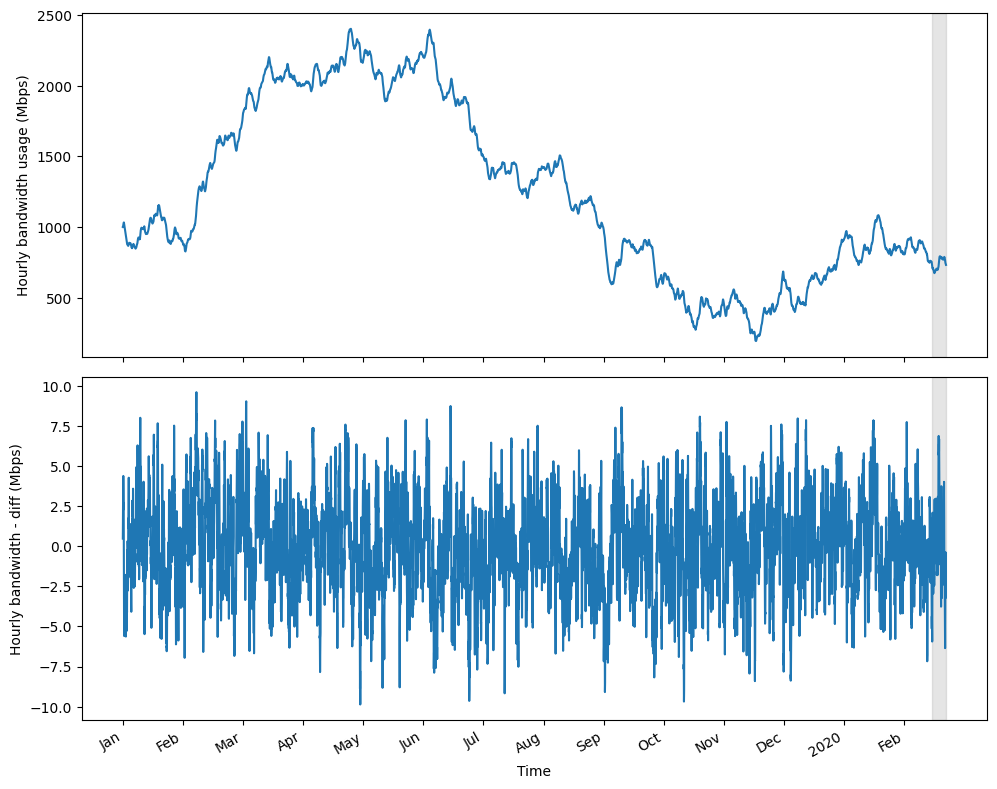

In [19]:
# Figure 6.16 in pg 126

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (Mbps)')
ax1.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax2.plot(df_diff['hourly_bandwidth_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (Mbps)')
ax2.axvspan(9830, 9999, color='#808080', alpha=0.2)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [20]:
def rolling_forecast(df: pd.Series, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1]#.values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(i, i + window - 1)   # changed from (0, i + window - 1) to (i, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [21]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1 #2

pred_mean = rolling_forecast(df['hourly_bandwidth'], TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df['hourly_bandwidth'], TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df['hourly_bandwidth'], TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_ARIMA'] = pred_ARIMA

pred_df.head()

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.019364,717.176939,711.698712
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.911321,708.114679,705.963069
9836,707.689774,1240.857042,707.024482,706.648886


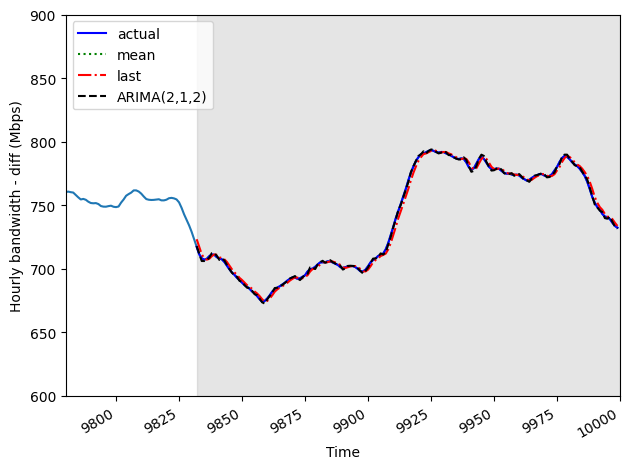

In [33]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(pred_df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(pred_df['pred_mean'], 'g:', label='mean')
ax.plot(pred_df['pred_last_value'], 'r-.', label='last')
ax.plot(pred_df['pred_ARIMA'], 'k--', label='ARIMA(2,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth - diff (Mbps)')

ax.axvspan(9832, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9780, 10000)
ax.set_ylim(600, 900)

# plt.xticks(
#     np.arange(0, 10000, 730), 
#     ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [23]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['hourly_bandwidth'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['hourly_bandwidth'], pred_df['pred_last_value'])
mse_ARIMA = mean_squared_error(pred_df['hourly_bandwidth'], pred_df['pred_ARIMA'])

print(mse_mean, mse_last, mse_ARIMA)

249682.48538603788 6.301585933788195 0.9004296674161429


In [24]:
df['pred_hourly_bandwidth'] = pred_df['pred_ARIMA']

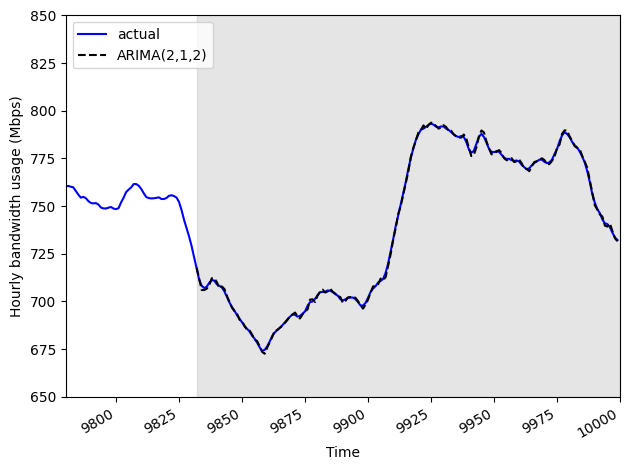

In [38]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_hourly_bandwidth'], 'k--', label='ARIMA(2,1,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwidth usage (Mbps)')

ax.axvspan(9832, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9780, 10000)
ax.set_ylim(650, 850)

# plt.xticks(
#     np.arange(0, 10000, 730), 
#     ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['hourly_bandwidth'].iloc[9832:], df['pred_hourly_bandwidth'].iloc[9832:])

print(mae_MA_undiff)

0.7839482203485678


CH06.ipynb: On average, our predictions are 14Mbps above or below the actual bandwidth usage

CH06_cumsum_error.ipynb: On average, our predictions are 0.8 Mbps above or below the actual bandwidth usage

CH07_exercise_7.5.1_6_2.1.2.ipynb: On average, our predictions are 0.8 Mbps above or below the actual bandwidth usage